In [156]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from scipy.stats import norm,t

In [196]:
dic = [ "amd","aapl", "ba", "biib", "jpm", "meta", "ngg", "pdd", "ryaay", "tsla",'nasdaq']
company_lst=[ "amd","aapl", "ba", "biib", "jpm", "meta", "ngg", "pdd", "ryaay", "tsla"]
in_path="stocks/"
for i, ticker in enumerate(dic):
    stock = in_path + f"{ticker}.csv"
    stock_df = pd.read_csv(stock, index_col="Date")[["Adj Close"]]
    if i == 0:
        df_close = stock_df
        df_close.columns = [ticker]
    else:
        df_close[ticker] = stock_df
df_close = df_close.dropna()
df_close.head()

amd        aapl          ba        biib         jpm  \
Date                                                                     
2022-01-03  150.240005  181.259933  207.860001  244.139999  156.752411   
2022-01-04  144.419998  178.959442  213.630005  241.729996  162.694855   
2022-01-05  136.149994  174.199158  213.070007  239.270004  159.720444   
2022-01-06  136.229996  171.291183  211.339996  237.300003  161.417328   
2022-01-07  132.000000  171.460495  215.500000  232.600006  163.016678   

                  meta        ngg        pdd       ryaay        tsla  \
Date                                                                   
2022-01-03  338.540009  70.250885  56.099998  106.440002  399.926666   
2022-01-04  336.529999  70.386894  49.820000  109.050003  383.196655   
2022-01-05  324.170013  69.706833  48.529999  110.250000  362.706665   
2022-01-06  332.459991  69.007339  52.130001  111.599998  354.899994   
2022-01-07  331.790009  69.570824  55.900002  115.989998  342.320007   

                  nasdaq  
Date                      
2022-01-03  15832.799805  
2022-01-04  15622.719727  
2022-01-05  15100.169922  
2022-01-06  15080.860352  
2022-01-07  14935.900391

In [197]:
df_return=df_close.pct_change().dropna()
df_return.head()

amd      aapl        ba      biib       jpm      meta  \
Date                                                                     
2022-01-04 -0.038738 -0.012692  0.027759 -0.009871  0.037910 -0.005937   
2022-01-05 -0.057264 -0.026600 -0.002621 -0.010177 -0.018282 -0.036728   
2022-01-06  0.000588 -0.016693 -0.008119 -0.008233  0.010624  0.025573   
2022-01-07 -0.031050  0.000988  0.019684 -0.019806  0.009908 -0.002015   
2022-01-10  0.000000  0.000116 -0.028724  0.011651  0.000957 -0.011212   

                 ngg       pdd     ryaay      tsla    nasdaq  
Date                                                          
2022-01-04  0.001936 -0.111943  0.024521 -0.041833 -0.013269  
2022-01-05 -0.009662 -0.025893  0.011004 -0.053471 -0.033448  
2022-01-06 -0.010035  0.074181  0.012245 -0.021523 -0.001279  
2022-01-07  0.008166  0.072319  0.039337 -0.035447 -0.009612  
2022-01-10 -0.000978  0.019499 -0.000172  0.030342  0.000464

## Portfolio VAR/ES based on past data (normal and t distribution)

In [200]:
date='2022-07-29'
stock_return=df_return.copy().loc[:date,:'tsla']
w = np.array([0.1]*10)
WeightedR = stock_return.mul(w, axis=1)

Return = WeightedR.sum(axis=1)

## Fit Normal
mu_norm, sig_norm = norm.fit(Return) # extract the mean and sigma of the closest normal distribution fit
print("Normal mean is {0:.8f}, sigma is {1:.8f}".format(mu_norm, sig_norm))
dx = 0.0001 # resolution of the distribution
x = np.arange(-1, 1, dx)
pdf_n = norm.pdf(x, mu_norm, sig_norm)

Normal mean is -0.00127502, sigma is 0.02423650


In [202]:
stock_return.head()

amd      aapl        ba      biib       jpm      meta  \
Date                                                                     
2022-01-04 -0.038738 -0.012692  0.027759 -0.009871  0.037910 -0.005937   
2022-01-05 -0.057264 -0.026600 -0.002621 -0.010177 -0.018282 -0.036728   
2022-01-06  0.000588 -0.016693 -0.008119 -0.008233  0.010624  0.025573   
2022-01-07 -0.031050  0.000988  0.019684 -0.019806  0.009908 -0.002015   
2022-01-10  0.000000  0.000116 -0.028724  0.011651  0.000957 -0.011212   

                 ngg       pdd     ryaay      tsla  
Date                                                
2022-01-04  0.001936 -0.111943  0.024521 -0.041833  
2022-01-05 -0.009662 -0.025893  0.011004 -0.053471  
2022-01-06 -0.010035  0.074181  0.012245 -0.021523  
2022-01-07  0.008166  0.072319  0.039337 -0.035447  
2022-01-10 -0.000978  0.019499 -0.000172  0.030342

In [203]:
## Fit T
nu, mu_t, sig_t = t.fit(Return)
nu = np.round(nu)
print("Student T mean is {0:.8f}, sigma is {1:.8f}, nu is {2}".format(mu_t, sig_t, nu))
pdf_t = t.pdf(x, nu, mu_t, sig_t)

Student T mean is -0.00142137, sigma is 0.02321965, nu is 25.0


In [204]:
h = 1
alpha = 0.01
xanu = t.ppf(alpha, nu)

CVaR_n = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_norm - mu_norm
VaR_n = norm.ppf(1-alpha)*sig_norm - mu_norm

VaR_t = np.sqrt((nu-2)/nu) * t.ppf(1-alpha, nu)*sig_norm  - h*mu_norm
CVaR_t = -1/alpha * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu)*sig_norm  - h*mu_norm

print("The 99% VaR (Normal) is {0:.2f}%".format(VaR_n*100))
print("The 99% CVaR (Normal) is {0:.2f}%".format(CVaR_n*100))
print("The 99% VaR (Student-t) is {0:.2f}%".format(VaR_t*100))
print("The 99% CVaR (Student-t) is {0:.2f}%".format(CVaR_t*100))

The 99% VaR (Normal) is 5.77%
The 99% CVaR (Normal) is 6.59%
The 99% VaR (Student-t) is 5.90%
The 99% CVaR (Student-t) is 6.73%


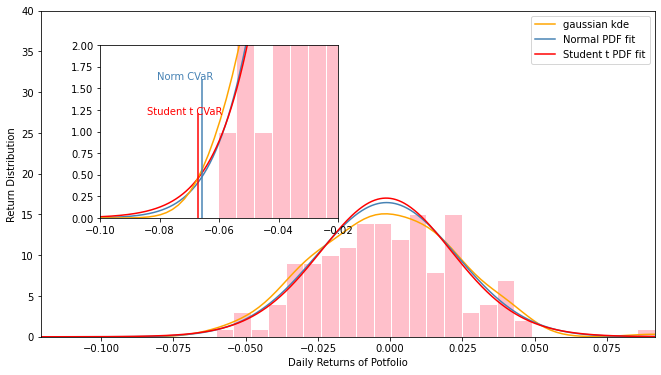

In [166]:
from scipy.stats import gaussian_kde
plt.figure(num=1, figsize=(11, 6))
# main figure
plt.hist(Return, bins=25, color='pink', edgecolor='white')
plt.axis("tight")
kde = gaussian_kde(Return)
xx = np.linspace(-0.1, 0.1, 100)
plt.plot(xx, kde(xx),'orange',label='gaussian kde')
plt.axis("tight")
plt.plot(x, pdf_n, 'steelblue', label="Normal PDF fit")
plt.axis("tight")
plt.plot(x, pdf_t, 'red', label="Student t PDF fit")
plt.xlim([min(Return)*2, max(Return)])
plt.ylim([0, 40])
plt.legend(loc="best")
plt.xlabel("Daily Returns of Potfolio")
plt.ylabel("Return Distribution")
# inset
a = plt.axes([.2, .4, .3, .4])
plt.hist(Return, bins=25, color='pink', edgecolor='white')
plt.plot(x, pdf_n, 'steelblue')
plt.plot(x, pdf_t, 'red')
plt.plot(xx, kde(xx),'orange')
# Student VaR line
plt.plot([-CVaR_t, -CVaR_t], [0, 1.2], c='red')
# Normal VaR line
plt.plot([-CVaR_n, -CVaR_n], [0, 1.6], c='steelblue')
plt.text(-CVaR_n-0.015, 1.6, "Norm CVaR", color='steelblue')
plt.text(-CVaR_t-0.0171, 1.2, "Student t CVaR", color='red')
plt.xlim([-0.1, -0.02])
plt.ylim([0, 2])
plt.show()

# LSTM

In [205]:
df_close.copy().loc['2022-10-03':,:].count()

amd       20
aapl      20
ba        20
biib      20
jpm       20
meta      20
ngg       20
pdd       20
ryaay     20
tsla      20
nasdaq    20
dtype: int64

In [206]:
df_close.copy().loc['2022-08-01':'2022-09-30',:].count()

amd       44
aapl      44
ba        44
biib      44
jpm       44
meta      44
ngg       44
pdd       44
ryaay     44
tsla      44
nasdaq    44
dtype: int64

In [207]:
def df_conversion(df, term_length):
    df=df.reset_index()
    N = df.shape[0]
    D = df.shape[1]
    cols = []

    for i in range(term_length, 0, -1):
        shift_df = df.shift(periods=i).copy()
        cols.append(shift_df.iloc[term_length:, :])

    X = pd.concat(cols, axis=1)

    # Close: regression task
    # Target: classification task
    Y = df[['Close']].copy()
    Y['Target'] = 0
    Y.loc[Y['Close'] - Y['Close'].shift(periods=1) > 0, 'Target'] = 1

    X = np.array(X).reshape([N-term_length, term_length, D])
    Y = Y.iloc[term_length:, :]

    return X, Y

In [208]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=10):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [209]:
class lstm(nn.Module):
    def __init__(self,dim, hidden_units=64):
        super(lstm,self).__init__()
        self.dim=dim
        self.hidden_units = hidden_units
        self.num_layers = 2
        self.lstm_0=nn.LSTM(self.dim,self.hidden_units,batch_first=True,num_layers=self.num_layers)
        self.out=nn.Linear(self.hidden_units, 1)
    def forward(self,x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        _, (hn, _)=self.lstm_0(x, (h0, c0))
        output=self.out(hn[0])
        return output

In [210]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SequenceData(Dataset):
    def __init__(self, X, y, batch=16):
        self.batch=batch
        self.y = torch.tensor(y).float()
        self.X = torch.tensor(X).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        return self.X[i], self.y[i]

In [227]:
def train(x,y,model,stock, term_length,epoch=5):
    val_length=44 # validation starting from 2021-08-01
    test_l=20
    scaler = MinMaxScaler(feature_range=(0, 1))
    X=df_close[['pdd','nasdaq']]
    X.columns=['Close','n_Close']
    X = pd.DataFrame(scaler.fit_transform(X).copy(),columns=['Close','n_Close'])    
    X_arr, Y_df = df_conversion(X, term_length)
    Y_arr = np.array(Y_df[y])
    train_X_arr, val_X_arr = X_arr[:-val_length-test_l, :,1:], X_arr[-val_length-test_l:-test_l, :,1:]
    train_Y_arr, val_Y_arr = Y_arr[:-val_length-test_l], Y_arr[-val_length-test_l:-test_l]
    train_data=SequenceData(train_X_arr,train_Y_arr)
    val_data=SequenceData(val_X_arr,val_Y_arr)
    train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    num_batches = len(train_loader)
    total_loss = 0
    X, y=next(iter(train_loader))
    for X, y in train_loader:
        output = model(X)
        loss = loss_function(torch.reshape(output,(-1,)), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")  
    val_output=model(torch.tensor(val_X_arr).float())
    val_loss=loss_function(torch.reshape(val_output,(-1,)),torch.tensor(val_Y_arr))
    print(f"Val loss: {val_loss}")
    return avg_loss,val_loss


In [219]:
df_close

amd        aapl          ba        biib         jpm  \
Date                                                                     
2022-01-03  150.240005  181.259933  207.860001  244.139999  156.752411   
2022-01-04  144.419998  178.959442  213.630005  241.729996  162.694855   
2022-01-05  136.149994  174.199158  213.070007  239.270004  159.720444   
2022-01-06  136.229996  171.291183  211.339996  237.300003  161.417328   
2022-01-07  132.000000  171.460495  215.500000  232.600006  163.016678   
...                ...         ...         ...         ...         ...   
2022-10-24   58.700001  149.449997  142.050003  274.619995  122.379997   
2022-10-25   61.470001  152.339996  146.649994  273.559998  122.699997   
2022-10-26   59.730000  149.350006  133.789993  280.429993  124.110001   
2022-10-27   58.599998  144.800003  139.759995  277.869995  124.599998   
2022-10-28   62.009998  155.740005  143.839996  284.290009  126.080002   

                  meta        ngg        pdd       ryaay        tsla  \
Date                                                                   
2022-01-03  338.540009  70.250885  56.099998  106.440002  399.926666   
2022-01-04  336.529999  70.386894  49.820000  109.050003  383.196655   
2022-01-05  324.170013  69.706833  48.529999  110.250000  362.706665   
2022-01-06  332.459991  69.007339  52.130001  111.599998  354.899994   
2022-01-07  331.790009  69.570824  55.900002  115.989998  342.320007   
...                ...        ...        ...         ...         ...   
2022-10-24  129.720001  51.970001  44.459999   63.430000  211.250000   
2022-10-25  137.509995  53.700001  47.529999   65.239998  222.419998   
2022-10-26  129.820007  53.790001  53.090000   67.269997  224.639999   
2022-10-27   97.940002  54.250000  53.110001   67.860001  225.089996   
2022-10-28   99.199997  55.299999  52.950001   67.860001  228.520004   

                  nasdaq  
Date                      
2022-01-03  15832.799805  
2022-01-04  15622.719727  
2022-01-05  15100.169922  
2022-01-06  15080.860352  
2022-01-07  14935.900391  
...                  ...  
2022-10-24  10952.610352  
2022-10-25  11199.120117  
2022-10-26  10970.990234  
2022-10-27  10792.669922  
2022-10-28  11102.450195  

[208 rows x 11 columns]

Epoch 0
---------
Train loss: 0.8456484739565187
Val loss: 0.03581228086229358
Epoch 1
---------
Train loss: 0.378727729121844
Val loss: 0.03608594876191679
Epoch 2
---------
Train loss: 0.3454175281027953
Val loss: 0.06311039385567992
Epoch 3
---------
Train loss: 0.1340544188602103
Val loss: 0.1862312000564805
Epoch 4
---------
Train loss: 0.5912823412153456
Val loss: 0.49422271676162716
Epoch 5
---------
Train loss: 0.15241097493304145
Val loss: 0.039423201068311646
Epoch 6
---------
Train loss: 0.07654643348521656
Val loss: 0.055538633606155734
Epoch 7
---------
Train loss: 0.05216804353727235
Val loss: 0.11707308925146784
Epoch 8
---------
Train loss: 0.030295883305370808
Val loss: 0.010273931873558502
Epoch 9
---------
Train loss: 0.038612695721288524
Val loss: 0.021955603932288938
Epoch 10
---------
Train loss: 0.039111939983235464
Val loss: 0.017658031362725965
Epoch 11
---------
Train loss: 0.03770046970910496
Val loss: 0.016711293751262915
Epoch 12
---------
Train loss: 0.029

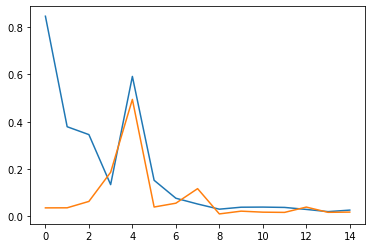

In [228]:
model=lstm(2)
train_loss=[]
val_loss=[]
for ix_epoch in range(15):
    print(f"Epoch {ix_epoch}\n---------")
    a,b=train(df_close, 'Close',model, 'pdd',10)
    train_loss.append(a)
    val_loss.append(b.detach().numpy())
plt.plot(train_loss)
plt.plot(val_loss)

scaler = MinMaxScaler(feature_range=(0, 1))
X=df_close[['pdd','nasdaq']]
X.columns=['Close','n_Close']
X = pd.DataFrame(scaler.fit_transform(X).copy(),columns=['Close','n_Close'])
X_arr, Y_df = df_conversion(X, 10)
Y_arr = np.array(Y_df['Close'])
model.eval()

res=model(torch.tensor(X_arr[:,:,1:]).float()).detach().numpy()


In [231]:
test=pd.DataFrame(Y_arr)
test['predicted']=res.reshape(-1)
import plotly.express as px
fig = px.line(test)
fig.add_vline(x=197-44, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.8, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.show()

Epoch 0
---------
Train loss: 0.4735440028210481
Val loss: 0.03679578920636758
Epoch 1
---------
Train loss: 0.29874907930692035
Val loss: 0.052366834593477726
Epoch 2
---------
Train loss: 0.12500236804286638
Val loss: 0.03109309223649663
Epoch 3
---------
Train loss: 0.14653697982430458
Val loss: 0.09060726025313896
Epoch 4
---------
Train loss: 0.07932698457605308
Val loss: 0.05695317649878311
Epoch 5
---------
Train loss: 0.048455261521869235
Val loss: 0.07127195392868363
Epoch 6
---------
Train loss: 0.02055363150106536
Val loss: 0.040586056738537796
Epoch 7
---------
Train loss: 0.025022765207621787
Val loss: 0.011716245446245133
Epoch 8
---------
Train loss: 0.01806240321861373
Val loss: 0.01765426286642187
Epoch 9
---------
Train loss: 0.02009490370336506
Val loss: 0.009100037769261474
Epoch 10
---------
Train loss: 0.018103647821893293
Val loss: 0.03131333827251653
Epoch 11
---------
Train loss: 0.013169302449872097
Val loss: 0.00823742795649189
Epoch 12
---------
Train loss: 

[0.006996235660181607,
 0.008746861046332476,
 0.009948157676396585,
 0.011097649100562695,
 0.04052355441982123,
 0.0475166256873571,
 0.004740136850350324,
 0.020169330671114306,
 0.010261558840326894,
 0.005208326195272652]

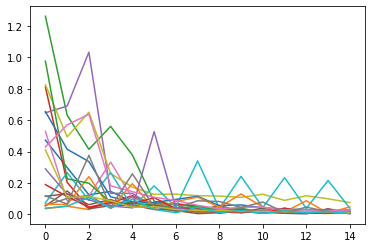

In [246]:
res={}
term_length=10
df_pred=pd.DataFrame(index=df_close.iloc[term_length:-20, :].index)
val_mse=[]
for stock in company_lst:
    model1=lstm(2)
    train_loss=[]
    val_loss=[]
    for ix_epoch in range(15):
        print(f"Epoch {ix_epoch}\n---------")
        a,b=train(df_close, 'Close',model1, stock,term_length)
        train_loss.append(a)
        val_loss.append(b.detach().item())
    plt.plot(train_loss)
    plt.plot(val_loss)
    val_mse.append(b.detach().item())
    scaler = MinMaxScaler(feature_range=(0, 1))
    X=df_close[[stock,'nasdaq']]
    X.columns=['Close','n_Close']
    min_=min(X['Close'])
    max_=max(X['Close'])
    X = pd.DataFrame(scaler.fit_transform(X).copy(),columns=['Close','n_Close'])



    X_s = pd.DataFrame(scaler.fit_transform(X).copy(),columns=['Close','n_Close'])
    X_arr, Y_df = df_conversion(X_s, term_length)
    df_pred[stock]=model1(torch.tensor(X_arr[:-20,:,1:]).float()).detach().numpy()*(max_-min_)+min_
val_mse

In [247]:
print('avergae validation mse:',sum(val_mse)/len(val_mse))

avergae validation mse: 0.016520843614771585


In [248]:
df_pred

amd        aapl          ba        biib         jpm  \
Date                                                                     
2022-01-18  125.706680  171.392151  203.113922  247.578522  141.342728   
2022-01-19  124.014297  170.602753  203.597107  241.170807  141.153839   
2022-01-20  122.586777  168.031082  201.929718  237.973618  141.085022   
2022-01-21  119.672302  167.372040  201.263748  232.704788  141.051529   
2022-01-24  118.550179  166.939240  199.378647  226.976562  140.980515   
...                ...         ...         ...         ...         ...   
2022-09-26   83.512970  158.563080  147.083328  200.129486  139.595917   
2022-09-27   82.332230  158.198654  143.086197  197.431244  139.465332   
2022-09-28   82.915810  158.856003  142.511063  199.301987  139.408585   
2022-09-29   83.948257  157.401230  146.528458  280.343628  139.518921   
2022-09-30   80.707161  151.139328  141.421219  280.616028  139.432007   

                  meta        ngg        pdd       ryaay        tsla  
Date                                                                  
2022-01-18  243.386154  71.221161  51.798069  107.003639  350.160156  
2022-01-19  239.198288  71.661621  53.001816  105.254974  346.728088  
2022-01-20  240.688660  71.993591  54.920040  105.744133  339.378113  
2022-01-21  239.852707  71.974541  56.414165  106.368286  339.067810  
2022-01-24  235.757980  71.872513  55.070007  105.931519  327.735962  
...                ...        ...        ...         ...         ...  
2022-09-26  130.953003  56.143646  56.631279   67.881943  300.804688  
2022-09-27  127.611725  52.817158  56.831734   65.360336  299.167053  
2022-09-28  125.340027  50.533585  56.961456   63.178593  303.781342  
2022-09-29  131.223526  52.355228  57.934319   63.907867  307.730133  
2022-09-30  127.517441  51.200752  57.060917   61.352798  294.571808  

[178 rows x 10 columns]

In [249]:
df_pred_r=(df_pred-df_pred.shift(periods=1))/df_pred.shift(periods=1)
df_pred_r

amd      aapl        ba      biib       jpm      meta  \
Date                                                                     
2022-01-18       NaN       NaN       NaN       NaN       NaN       NaN   
2022-01-19 -0.013463 -0.004606  0.002379 -0.025882 -0.001336 -0.017207   
2022-01-20 -0.011511 -0.015074 -0.008190 -0.013257 -0.000488  0.006231   
2022-01-21 -0.023775 -0.003922 -0.003298 -0.022140 -0.000237 -0.003473   
2022-01-24 -0.009377 -0.002586 -0.009366 -0.024616 -0.000503 -0.017072   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.018353 -0.009118 -0.038724 -0.014182 -0.000756 -0.013816   
2022-09-27 -0.014138 -0.002298 -0.027176 -0.013482 -0.000935 -0.025515   
2022-09-28  0.007088  0.004155 -0.004019  0.009475 -0.000407 -0.017802   
2022-09-29  0.012452 -0.009158  0.028190  0.406627  0.000791  0.046940   
2022-09-30 -0.038608 -0.039783 -0.034855  0.000972 -0.000623 -0.028243   

                 ngg       pdd     ryaay      tsla  
Date                                                
2022-01-18       NaN       NaN       NaN       NaN  
2022-01-19  0.006184  0.023239 -0.016342 -0.009801  
2022-01-20  0.004632  0.036192  0.004647 -0.021198  
2022-01-21 -0.000265  0.027205  0.005902 -0.000914  
2022-01-24 -0.001418 -0.023827 -0.004106 -0.033421  
...              ...       ...       ...       ...  
2022-09-26 -0.045963 -0.032552 -0.032773 -0.035803  
2022-09-27 -0.059250  0.003540 -0.037147 -0.005444  
2022-09-28 -0.043235  0.002283 -0.033380  0.015424  
2022-09-29  0.036048  0.017079  0.011543  0.012999  
2022-09-30 -0.022051 -0.015076 -0.039981 -0.042759  

[178 rows x 10 columns]

In [256]:
df_return

amd      aapl        ba      biib       jpm      meta  \
Date                                                                     
2022-01-04 -0.038738 -0.012692  0.027759 -0.009871  0.037910 -0.005937   
2022-01-05 -0.057264 -0.026600 -0.002621 -0.010177 -0.018282 -0.036728   
2022-01-06  0.000588 -0.016693 -0.008119 -0.008233  0.010624  0.025573   
2022-01-07 -0.031050  0.000988  0.019684 -0.019806  0.009908 -0.002015   
2022-01-10  0.000000  0.000116 -0.028724  0.011651  0.000957 -0.011212   
...              ...       ...       ...       ...       ...       ...   
2022-10-24 -0.002040  0.014803  0.005166  0.026156  0.001227 -0.002231   
2022-10-25  0.047189  0.019338  0.032383 -0.003860  0.002615  0.060052   
2022-10-26 -0.028307 -0.019627 -0.087692  0.025113  0.011491 -0.055923   
2022-10-27 -0.018918 -0.030465  0.044622 -0.009129  0.003948 -0.245571   
2022-10-28  0.058191  0.075553  0.029193  0.023104  0.011878  0.012865   

                 ngg       pdd     ryaay      tsla    nasdaq  
Date                                                          
2022-01-04  0.001936 -0.111943  0.024521 -0.041833 -0.013269  
2022-01-05 -0.009662 -0.025893  0.011004 -0.053471 -0.033448  
2022-01-06 -0.010035  0.074181  0.012245 -0.021523 -0.001279  
2022-01-07  0.008166  0.072319  0.039337 -0.035447 -0.009612  
2022-01-10 -0.000978  0.019499 -0.000172  0.030342  0.000464  
...              ...       ...       ...       ...       ...  
2022-10-24  0.021022 -0.246057  0.000315 -0.014876  0.008554  
2022-10-25  0.033288  0.069051  0.028535  0.052876  0.022507  
2022-10-26  0.001676  0.116979  0.031116  0.009981 -0.020370  
2022-10-27  0.008552  0.000377  0.008771  0.002003 -0.016254  
2022-10-28  0.019355 -0.003013  0.000000  0.015238  0.028703  

[207 rows x 11 columns]

In [263]:
### Avg predicted return error of past n days:
def cal_mean_return_error(actual,pred,n):
    a=actual-pred
    tmp=a.copy()
    for i in range(n-1):
        a=a+tmp.shift(periods=i+1)
    return a.shift(1)/10
mean_return_error_10=cal_mean_return_error(df_return.iloc[:,:10],df_pred_r,10)

In [264]:
mean_return_error_10=mean_return_error_10.iloc[20:,:]

In [265]:
mean_return_error_10.loc['2022-09-30',:]

amd     -0.009578
aapl    -0.004098
ba      -0.007384
biib    -0.005494
jpm     -0.010014
meta    -0.001775
ngg      0.002595
pdd     -0.005128
ryaay   -0.001430
tsla    -0.008456
Name: 2022-09-30, dtype: float64

In [267]:
risk_free=0.0404 #for Oct 26 2022
stock_return  = stock_return.iloc[:,:10].copy()
def get_optimal_portfolio(num=10000,date='2022-09-30',method='mv'):
    random_p = np.empty((num, 12))
    ### set a random seed so that optimal potfolio might not change over consecutive date
    np.random.seed(7) 
    for i in range(num):
        random10=np.random.random(10)
        random_weight=random10/np.sum(random10)
        mean_return=stock_return.loc[:date,:].mul(random_weight,axis=1).sum(axis=1).mean()
        annual_return=mean_return * 252
#         annual_return=(1+mean_return)**stock_return.loc[:date,:].shape[0]-1
        cov_mat = stock_return.loc[:date,:].cov()
        cov_mat_annual = cov_mat * 252
        random_volatility=np.sqrt(np.dot(random_weight.T,np.dot(cov_mat_annual,random_weight)))
        pred_return=df_pred_r.loc[date,:].mul(random_weight).sum()
        return_error=mean_return_error_10.loc[date,:].mul(random_weight).sum()
        neg_sharpe_ratio = -(annual_return-risk_free)/random_volatility
    # Minimize var and maximize expected portfolio return and sample period’s abnormal return
        if method == 'mv':
            obj_f=random_volatility-2*pred_return-2*return_error
        elif method == 'sharpe':
            obj_f= neg_sharpe_ratio-2*pred_return-2*return_error
            
        random_p[i][:10]=random_weight
        random_p[i][10]=annual_return
        random_p[i][11]=obj_f
      
    RandomPortfolios=pd.DataFrame(random_p)
    RandomPortfolios.columns=[company +'_weight' for company in company_lst]+['Returns','Obj']

    min_index = RandomPortfolios.Obj.idxmin()

    RandomPortfolios.plot('Obj', 'Returns', kind='scatter', alpha=0.3)
    x = RandomPortfolios.loc[min_index,'Obj']
    y = RandomPortfolios.loc[min_index,'Returns']
    plt.scatter(x, y, color='red')

    plt.text(np.round(x,4),np.round(y,4),(np.round(x,4),np.round(y,4)),ha='left',va='bottom',fontsize=10)
    plt.show()

    numstocks = 10

    GMV_weights = np.array(RandomPortfolios.iloc[min_index, 0:numstocks])

    return GMV_weights

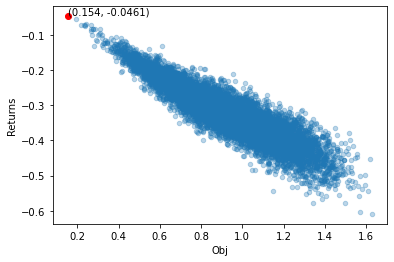

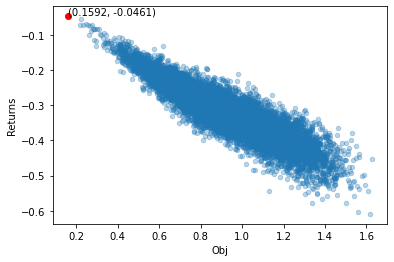

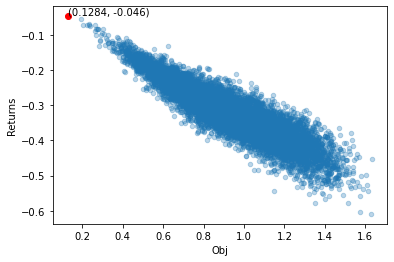

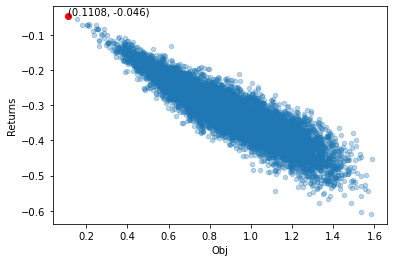

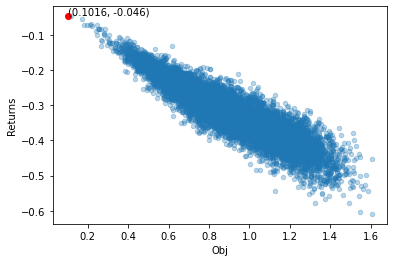

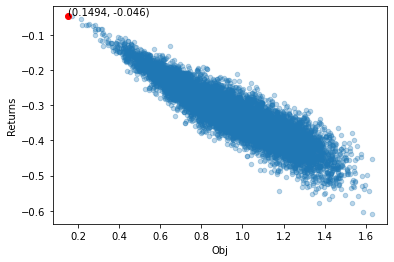

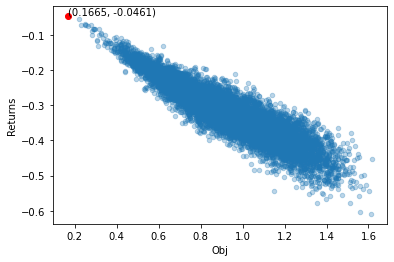

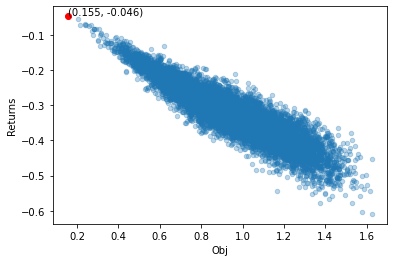

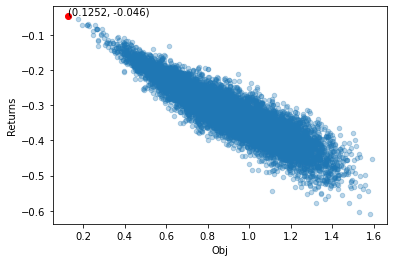

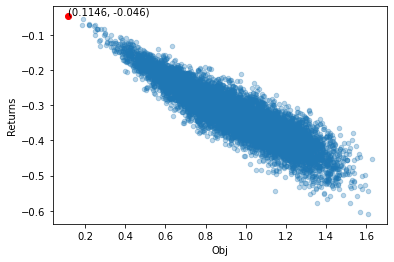

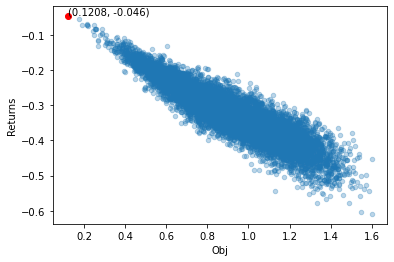

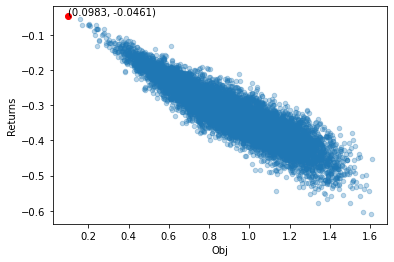

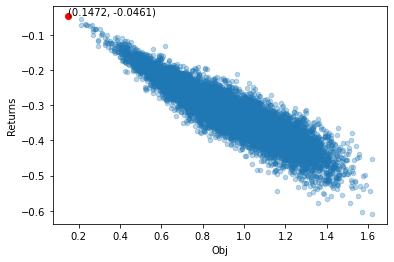

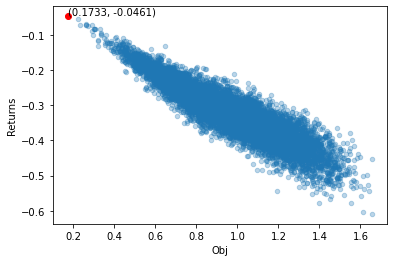

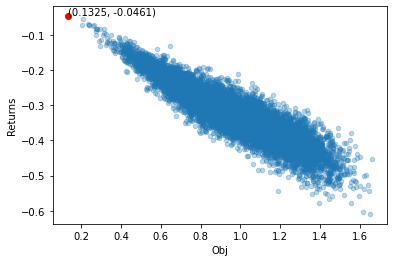

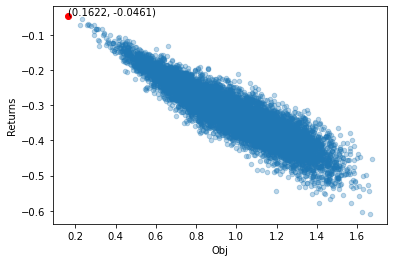

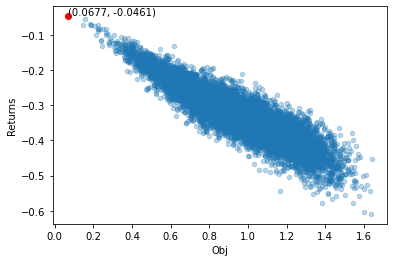

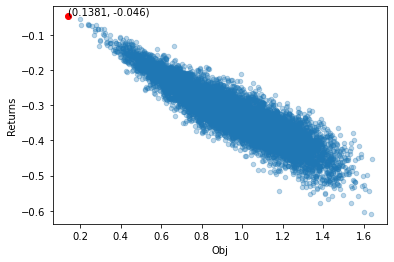

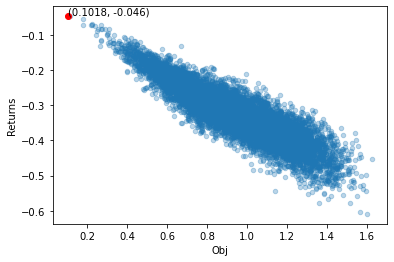

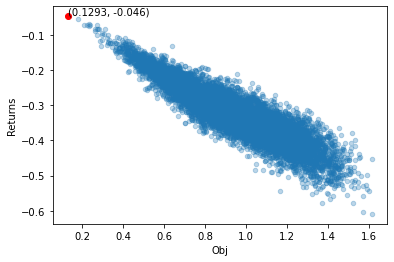

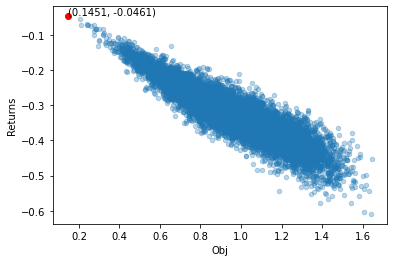

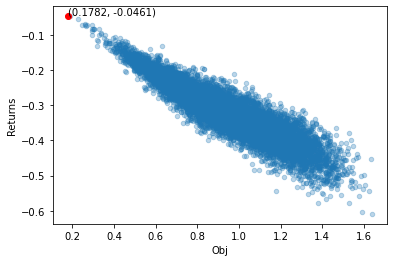

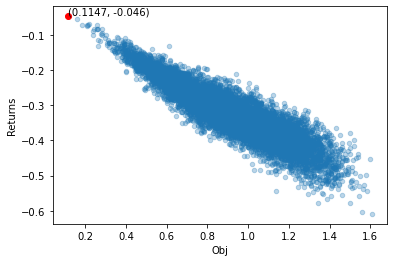

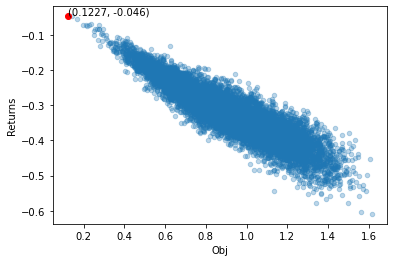

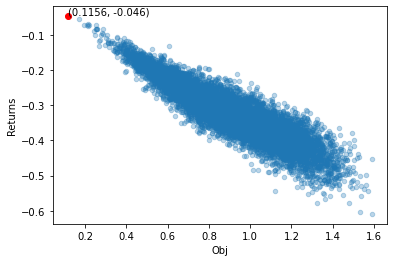

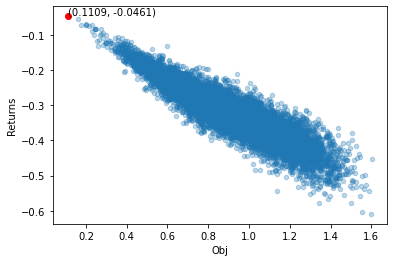

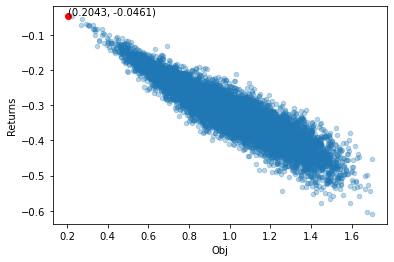

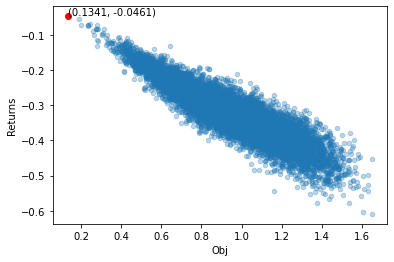

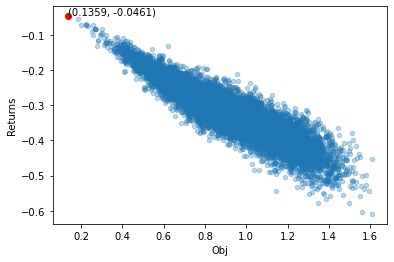

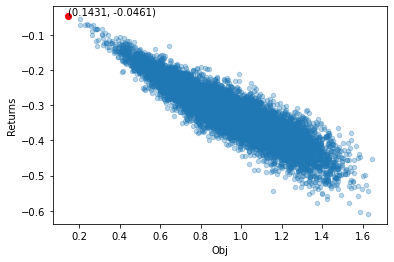

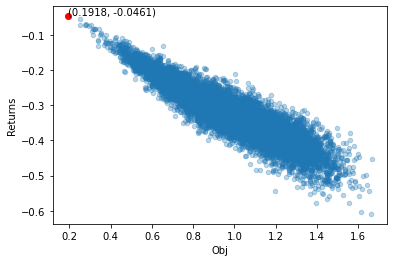

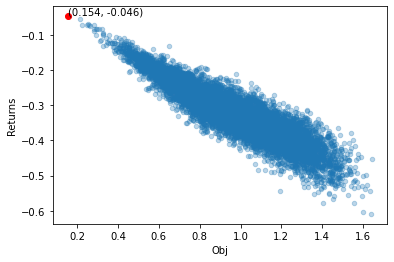

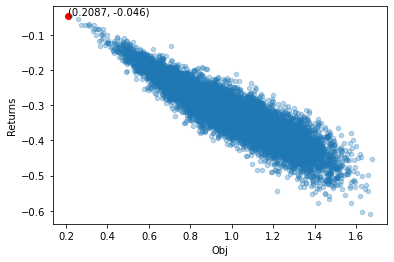

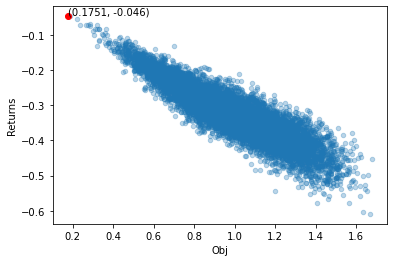

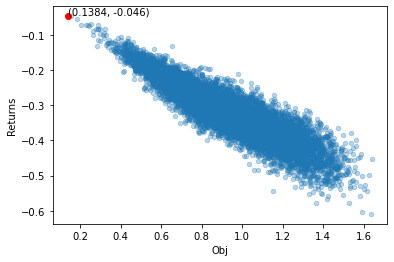

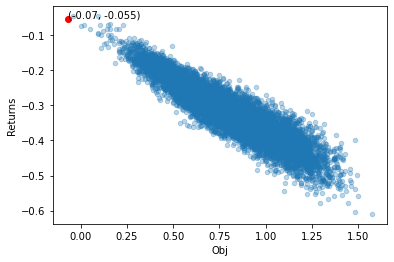

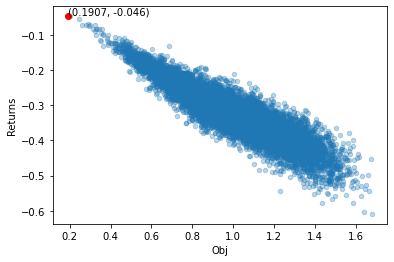

In [268]:
#### get daily optimal weight for Aug and Sep
weight={}
date_list=df_close.iloc[-64:-20, :].index
for date in date_list:
    weight[date]=get_optimal_portfolio(num=10000,date=date,method='sharpe')

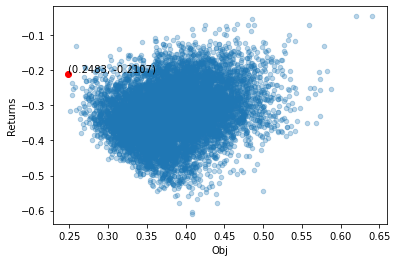

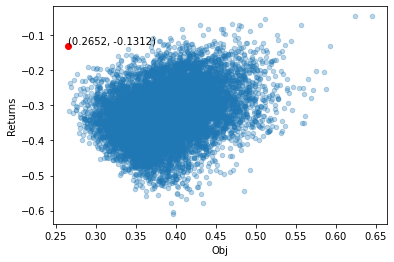

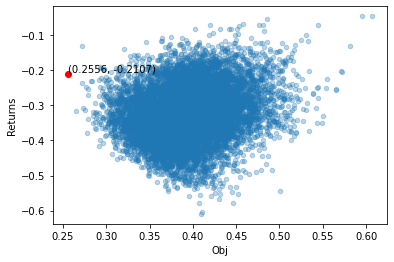

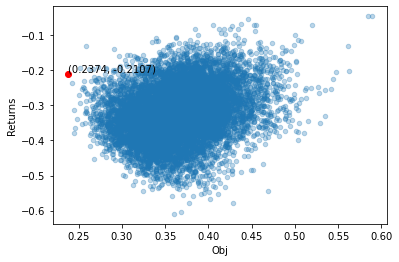

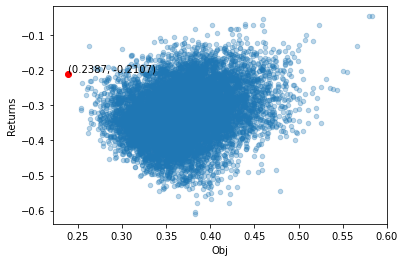

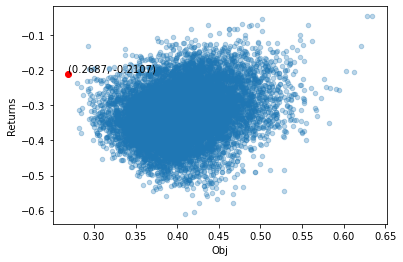

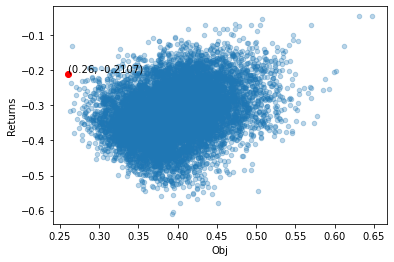

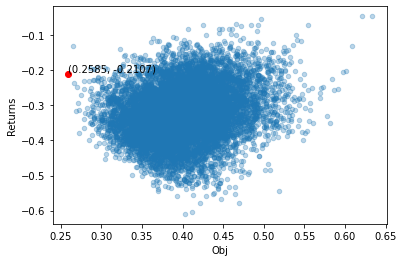

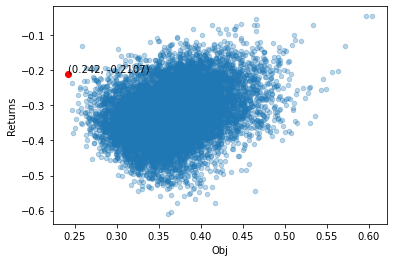

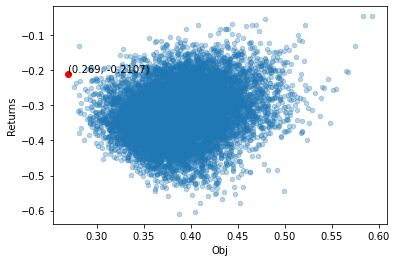

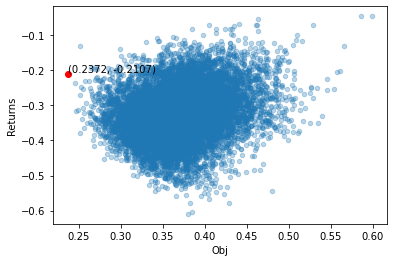

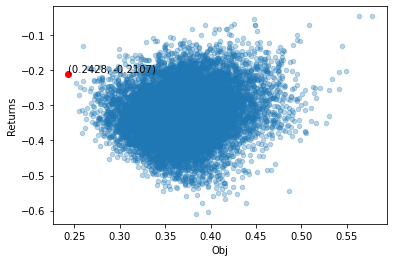

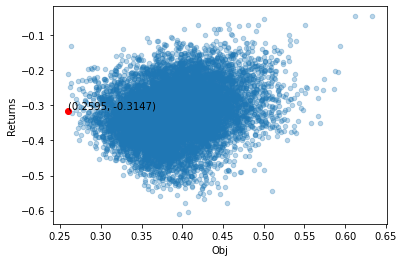

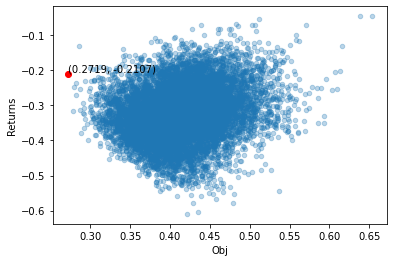

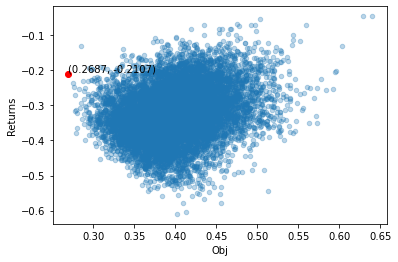

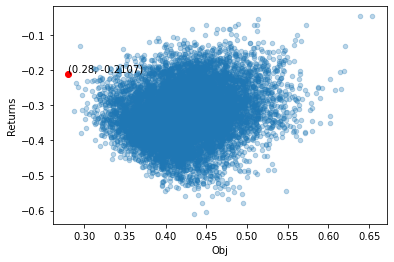

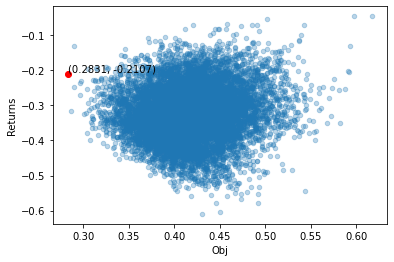

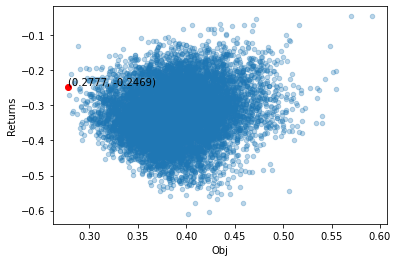

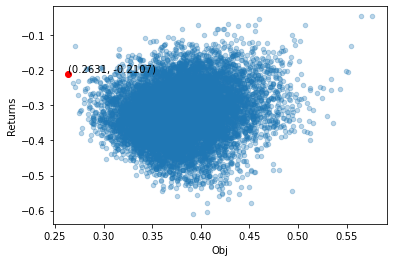

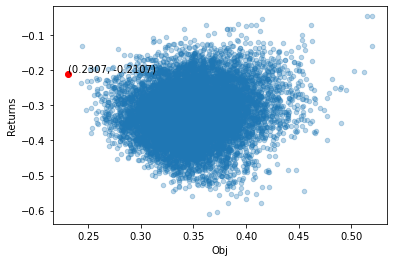

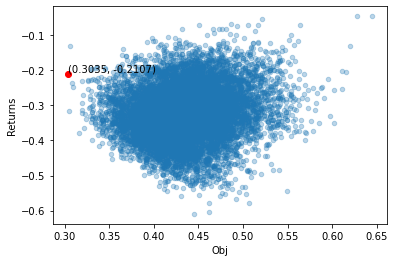

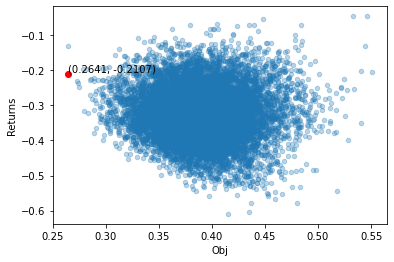

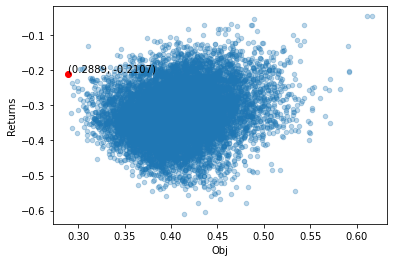

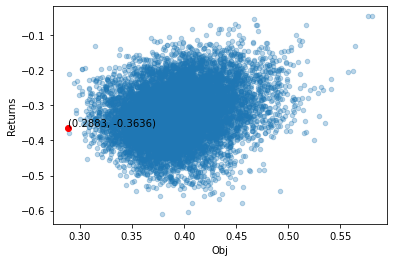

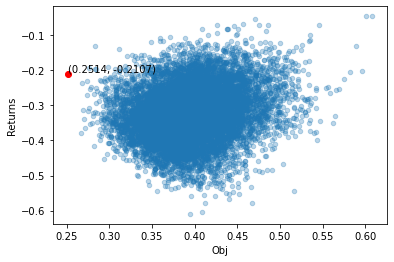

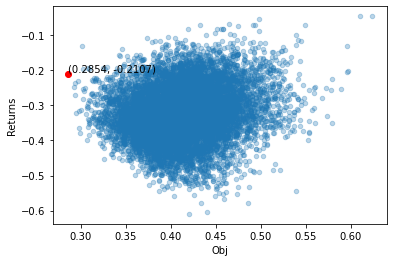

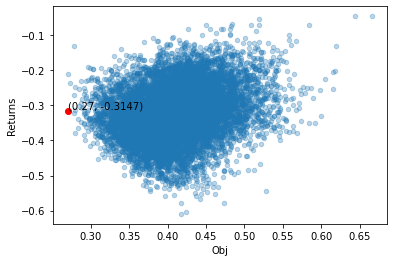

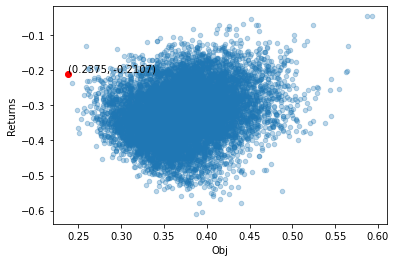

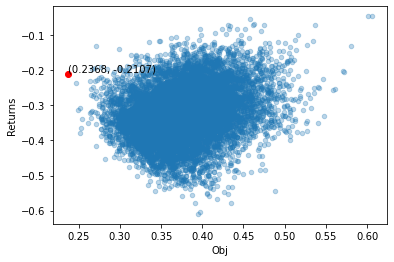

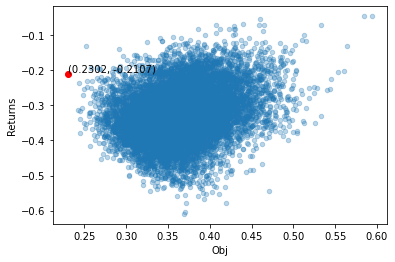

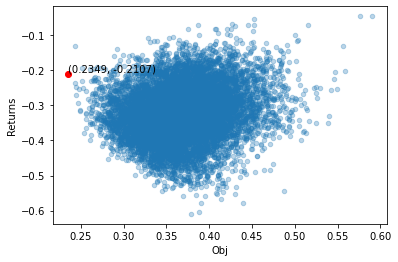

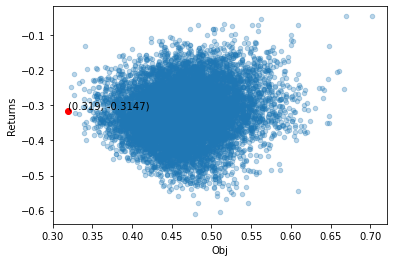

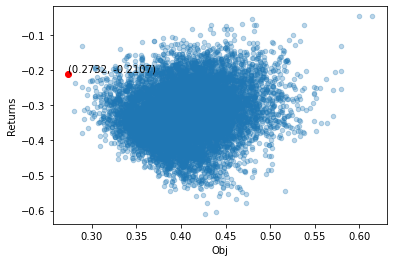

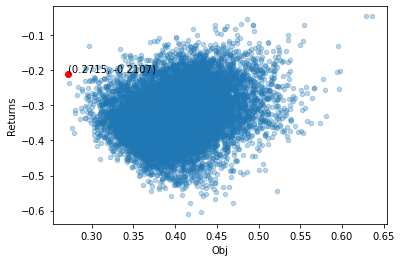

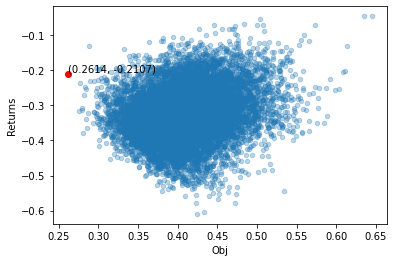

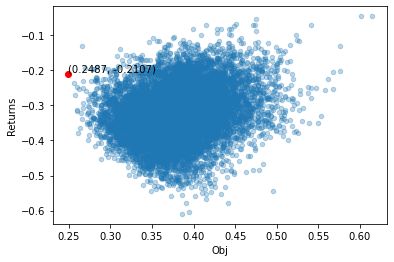

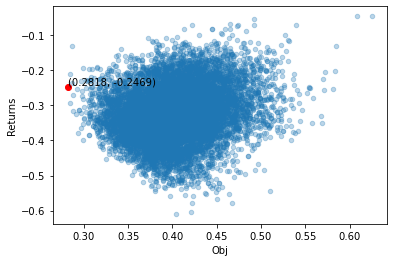

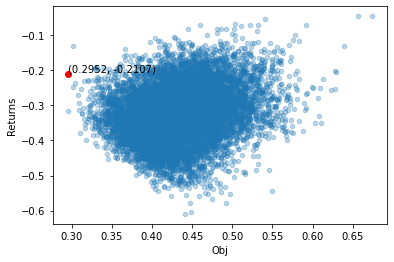

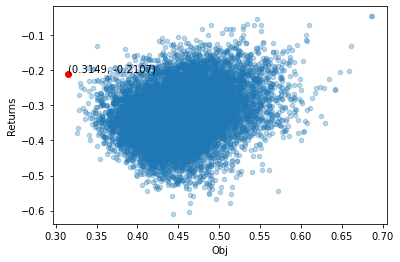

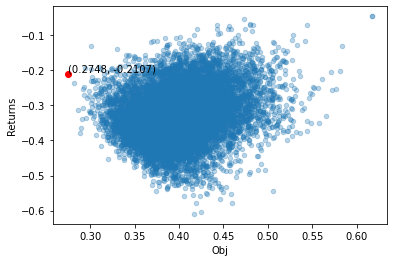

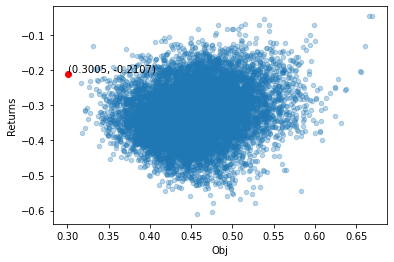

In [269]:
#### get daily optimal weight for Aug and Sep
weight_2={}
date_list=df_close.iloc[-64:-20, :].index
for date in date_list:
    weight_2[date]=get_optimal_portfolio(num=10000,date=date,method='mv')


In [281]:
### Return for Aug and Sep (Sharpe + Prediction)
WeightedReturns=df_return.loc['2022-08-01':'2022-09-30',:'tsla']*pd.DataFrame.from_dict(weight, orient='index',columns=company_lst)
plt.plot(WeightedReturns.sum(axis=1))
plt.show()
print("Portfolio validation period return: {0:.2f}%".format((np.prod(1+WeightedReturns.sum(axis=1))-1)*100))

Portfolio validation period return: 6.05%


In [279]:
stock_return

amd      aapl        ba      biib       jpm      meta  \
Date                                                                     
2022-01-04 -0.038738 -0.012692  0.027759 -0.009871  0.037910 -0.005937   
2022-01-05 -0.057264 -0.026600 -0.002621 -0.010177 -0.018282 -0.036728   
2022-01-06  0.000588 -0.016693 -0.008119 -0.008233  0.010624  0.025573   
2022-01-07 -0.031050  0.000988  0.019684 -0.019806  0.009908 -0.002015   
2022-01-10  0.000000  0.000116 -0.028724  0.011651  0.000957 -0.011212   
...              ...       ...       ...       ...       ...       ...   
2022-07-25 -0.006356 -0.007398 -0.009611  0.006400  0.004008 -0.015478   
2022-07-26 -0.026159 -0.008826 -0.004597  0.015802 -0.015622 -0.045005   
2022-07-27  0.053607  0.034235  0.001090  0.009817  0.016047  0.065536   
2022-07-28  0.020597  0.003572  0.019220  0.006012 -0.003731 -0.052247   
2022-07-29  0.030544  0.032793  0.001383  0.004015  0.004791 -0.010080   

                 ngg       pdd     ryaay      tsla  
Date                                                
2022-01-04  0.001936 -0.111943  0.024521 -0.041833  
2022-01-05 -0.009662 -0.025893  0.011004 -0.053471  
2022-01-06 -0.010035  0.074181  0.012245 -0.021523  
2022-01-07  0.008166  0.072319  0.039337 -0.035447  
2022-01-10 -0.000978  0.019499 -0.000172  0.030342  
...              ...       ...       ...       ...  
2022-07-25  0.015174  0.033652  0.046358 -0.013995  
2022-07-26  0.008140 -0.018680 -0.040129 -0.035664  
2022-07-27 -0.001762 -0.003082  0.029602  0.061655  
2022-07-28  0.010294 -0.074195 -0.002861  0.022124  
2022-07-29  0.013246 -0.037321 -0.002460  0.057850  

[143 rows x 10 columns]

In [282]:
### Return for Aug and Sep (MV + Prediction)
WeightedReturns=df_return.loc['2022-08-01':'2022-09-30',:'tsla']*pd.DataFrame.from_dict(weight_2, orient='index',columns=company_lst)
plt.plot(WeightedReturns.sum(axis=1))
plt.show()
print("Portfolio validation period return: {0:.2f}%".format((np.prod(1+WeightedReturns.sum(axis=1))-1)*100))

Portfolio validation period return: -7.68%


### Test Result (Oct)

In [283]:
test_df = df_return.loc['2022-10-03':,:'tsla']

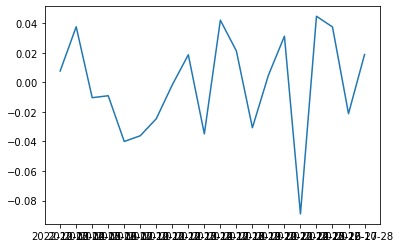

Portfolio test period return: -4.49%


In [284]:
### Return based on (Sharpe + Prediction) last date weight
WeightedReturns=test_df.mul(weight['2022-09-30'], axis=1)
plt.plot(WeightedReturns.sum(axis=1))
plt.show()
print("Portfolio test period return: {0:.2f}%".format((np.prod(1+WeightedReturns.sum(axis=1))-1)*100))

In [285]:
### Return based on (Sharpe + Prediction) last date weight
WeightedReturns=test_df.mul(weight_2['2022-09-30'], axis=1)
plt.plot(WeightedReturns.sum(axis=1))
plt.show()
print("Portfolio test period return: {0:.2f}%".format((np.prod(1+WeightedReturns.sum(axis=1))-1)*100))

Portfolio test period return: 6.98%


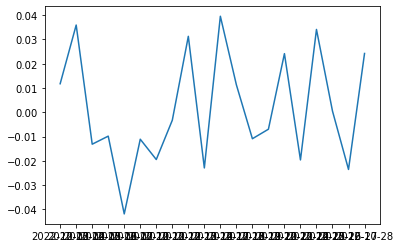

Portfolio test period return: 2.51%


In [286]:
portfolio_weights = np.array([0.1]*10)
WeightedReturns=test_df.mul(portfolio_weights, axis=1)
plt.plot(WeightedReturns.sum(axis=1))
plt.show()
print("Portfolio test period return: {0:.2f}%".format((np.prod(1+WeightedReturns.sum(axis=1))-1)*100))